In [ ]:
import sys
# sys.path.append('/content/ML_Forex_Forecasting')
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
# from generate_features import generate_features
# from maximum_profit_path import find_maximum_profit_path
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
from statsmodels.tsa.stattools import adfuller

## Dickey-Fuller Test

In [ ]:
def dickey_fuller_test(df,var):
    result = adfuller(df[var].values)
    #Extracting the values from the results:
    print(f"Dickey-Fuller test for feature: {var}")

    print('Test Statistic: %f' % result[0])

    print('p-value: %f' % result[1])

    print('Critical Values:')

    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[0] < result[4]["5%"]:
        print ("Reject H0 - Time Series is Stationary")
    else:
        print ("Failed to Reject H0 - Time Series is Non-Stationary")

In [2]:
# usd_eur = pd.read_csv("/content/ML_Forex_Forecasting/USDEUR=X.csv", parse_dates=['Date'])
# usd_gbp = pd.read_csv("/content/ML_Forex_Forecasting/USDGBP=X.csv", parse_dates=['Date'])
# usd_chf = pd.read_csv("/content/ML_Forex_Forecasting/USDCHF=X.csv", parse_dates=['Date'])

usd_eur = pd.read_csv("./USDEUR=X (3).csv", parse_dates=['Date'])
usd_eur = usd_eur[['Date', 'Close']]

gold_prices = pd.read_csv("./GC=F.csv", parse_dates=['Date'])
gold_prices = gold_prices[['Date', 'Close']]
gold_prices.rename(columns = {'Close':'Gold_Price'}, inplace = True)

GSPC = pd.read_csv("./GSPC.csv", parse_dates=['Date'])
GSPC = GSPC[['Date', 'Close']]
GSPC.rename(columns = {'Close':'GSPC'}, inplace = True)

S50 = pd.read_csv("./EUROSTOXX50E.csv", parse_dates=['Date'])
S50 = S50[['Date', 'Close']]
S50.rename(columns = {'Close':'S50'}, inplace = True)

# FTSE = pd.read_csv("./FTSE.csv", parse_dates=['Date'])
# FTSE = FTSE[['Date', 'Close']]
# FTSE.rename(columns = {'Close':'FTSE'}, inplace = True)

usd_eur = usd_eur.merge(gold_prices, on='Date')
usd_eur = usd_eur.merge(S50, on='Date')
usd_eur = usd_eur.merge(GSPC, on='Date')

# eur_gbp = eur_gbp.iloc[::-1]

# eur_chf = pd.read_csv("/content/ML_Forex_Forecasting/EURCHF=X.csv", parse_dates=['Date'])
# gbp_chf = pd.read_csv("/content/ML_Forex_Forecasting/GBPCHF=X.csv", parse_dates=['Date'])
# print(f"USD/EUR: {usd_eur.shape}")
# display(usd_eur.head())
# print(f"USD/GBP: {usd_gbp.shape}")
# display(usd_gbp.head())
# print(f"USD/CHF: {usd_chf.shape}")
# display(usd_chf.head())
print(f"USD/EUR: {usd_eur.shape}")
display(usd_eur.head(20))


# print(f"EUR/CHF: {eur_chf.shape}")
# display(eur_chf.head())
# print(f"GBP/CHF: {gbp_chf.shape}")
# display(gbp_chf.head())

USD/EUR: (247, 5)


,Date,Close,Gold_Price,S50,GSPC
0,2022-11-18,0.96509,1751.900024,3924.840088,3965.340088
1,2022-11-21,0.96797,1737.400024,3909.280029,3949.939941
2,2022-11-22,0.97602,1738.300049,3929.899902,4003.580078
3,2022-11-23,0.96983,1744.900024,3946.439941,4027.260010
4,2022-11-25,0.96079,1753.300049,3962.409912,4026.120117
5,2022-11-28,0.96455,1740.099976,3935.510010,3963.939941
6,2022-11-29,0.96660,1748.400024,3934.439941,3957.629883
7,2022-11-30,0.96857,1746.000000,3964.719971,4080.110107
8,2022-12-01,0.95920,1801.099976,3984.500000,4076.570068
9,2022-12-02,0.94981,1795.900024,3977.899902,4071.699951


In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.statespace.tools import diff

data = usd_eur.copy()
df = data.dropna()

train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

data = train[['Close','Gold_Price','S50','GSPC']]

diff_data = diff(data, k_diff=1)

p = np.arange(1,6)
q = np.arange(1,6)
models = []
orders = []
MSEs = []
for i in p:
    for j in q:
        orders.append((i,j))
        model = VARMAX(diff_data, order=(i,j), mle_regression = True, filter_concentrated = True)
        model_fit = model.fit(disp=False)
        pred = pd.DataFrame()
        pred['prediction'] = data.iloc[-1]['Close'] + model_fit.forecast(5).reset_index(drop=True).Close
        pred['observed'] = test.reset_index(drop=True).Close
        models.append(model_fit)
        MSEs.append(np.mean((pred['prediction'].values-pred['observed'].values)**2))

/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/amaankazi/miniconda3/envs/mlsp/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models

In [98]:
np.argmin(MSEs)

10

In [101]:
orders[10]

(3, 1)

In [34]:
model_fit = pickle.load(open("./usd_eur_models/model_3_1_best.pkl","rb"))

In [104]:
model_fit = models[10]

Text(0.5, 1.0, 'MSE = 1.5665483004254946e-05')

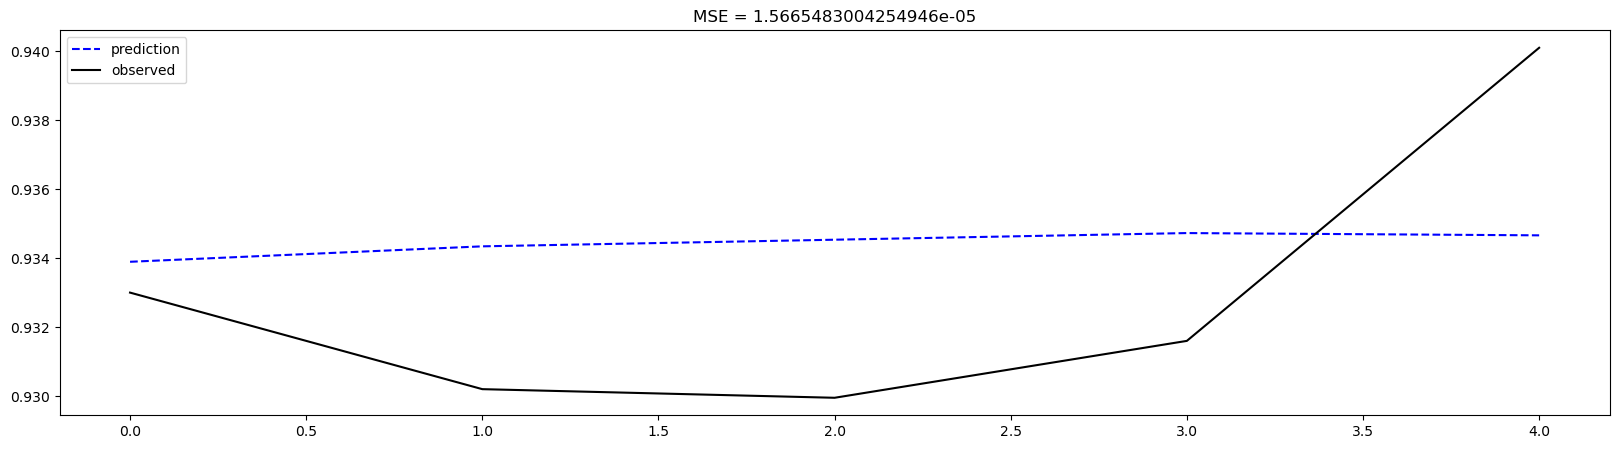

In [116]:
# plot prediction vs observed
pred = pd.DataFrame()
pred['prediction'] = data.iloc[-1]['Close'] + model_fit.forecast(5).reset_index(drop=True).Close
pred['observed'] = test.reset_index(drop=True).Close

pred.plot(figsize=(20,5),title='prediction vs observed',color=['blue','black'],style=['--','-'])
plt.title(f"MSE = {np.mean((pred['prediction'].values-pred['observed'].values)**2)}")

In [76]:
print(pred)

   prediction  observed
0    0.927800   0.93300
1    0.927950   0.93020
2    0.938693   0.92995
3    0.935744   0.93160
4    0.936285   0.94010


In [106]:
import pickle
pickle.dump(model_fit, open("./usd_eur_models/model_3_1_best.pkl","wb"))